In [50]:
#Se importan las librerias requeridas para el correcto funcionamiento del código.
from scipy import interpolate 
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from scipy.optimize import newton

In [133]:
global x1 #Definimos la variable global de x1
x1 = 0
global y1 #Definimos la variable global de y1
y1 = 0
global x2 #Definimos la variable global de x2
x2 = 1
global y2 #Definimos la variable global de y2
y2 = -5
global nc #Definimos la variable global de la dimension del problema
nc = 29
global k #Definimos la variable del grado del Bspline
k = 3
global np #Definimos la variable global de la dimension del problema
nbp = nc + k + 1
global t #Definimos los nodos de control, igualmente espaciados, de tamaño nc
t = np.linspace(0,x2,nbp)
tt = [0.5*(x1+x2)-0.5*(x2-x1)*(np.cos((2 * i + 1) * np.pi / (2 * (nbp-2)))) for i in range(nbp-2)]
t=np.concatenate([[0], tt, [x2]])
print(t)
xx = np.linspace(0,1,100) #Creamos un vector de valores para x
#c = np.linspace(-0.1,-.2, nc) #Creamos un vector de nodos de control
c= np.zeros(nc)
print(c)

[0.00000000e+00 6.41746414e-04 5.76583784e-03 1.59614406e-02
 3.11239339e-02 5.10977302e-02 7.56778713e-02 1.04612132e-01
 1.37603606e-01 1.74313759e-01 2.14365892e-01 2.57349019e-01
 3.02822072e-01 3.50318439e-01 3.99350740e-01 4.49415839e-01
 5.00000000e-01 5.50584161e-01 6.00649260e-01 6.49681561e-01
 6.97177928e-01 7.42650981e-01 7.85634108e-01 8.25686241e-01
 8.62396394e-01 8.95387868e-01 9.24322129e-01 9.48902270e-01
 9.68876066e-01 9.84038559e-01 9.94234162e-01 9.99358254e-01
 1.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


In [134]:
bandera = 3 #Se cambia el valor dependiendo de la funcion y su derivada a usar
if (bandera == 1): #Se toma una funcion lineal
    funcion = lambda x: y1 + ((x-x1)/(x2-x1))*(y2-y1)
    derivada_funcion = lambda x: (y2-y1)/(x2-x1)
elif (bandera == 2): #Se toma una funcion cuadratica
    funcion = lambda x: x*((x-x2)+y2)/x2
    derivada_funcion = lambda x: (x-x2+y2)/x2+x/x2
elif (bandera == 3):#Se toma una funcion exponencial
    a=1
    funcion = lambda x: y2*(np.exp(-a*x)-1)/(np.exp(-a*x2)-1)
    derivada_funcion = lambda x: (-a*np.exp(-a*x)*y2)/(np.exp(-a*x2)-1)
funcion_vector = np.vectorize(funcion) #Se vectoriza la funcion con tal de que si recibe un arreglo de numeros, regrese un arreglo
derivada_vector = np.vectorize(derivada_funcion)

In [135]:
#Funcion basada en la propuesta por:
#Christian. (2017). The Brachistochrone problem. agosto 09, 2021, de Scipy Python Sitio web: https://scipython.com/blog/the-brachistochrone-problem/
def cycloid(x2, y2, N): #Definimos la funcion auxiliar para graficar la cicloide, que devuelve los valores de x, y y el radio
   
    
    def f(theta): 
        return -y2/x2 - (1-np.cos(theta))/(theta-np.sin(theta))
    theta2 = newton(f, np.pi/20, maxiter= 150)

    
    R = -y2 / (1 - np.cos(theta2))

    theta = np.linspace(0, theta2, N)
    x = R * (theta - np.sin(theta))
    y = R * (1 - np.cos(theta))

    return x, -y, R #Se regresan los valores para la construccion de la cicloide

In [136]:
#Funcion que regresa los valores de la cicloide dados los valores de x y un radio R dados
def ycycloid(x, R):
    def f(theta):
        return R * (theta - np.sin(theta))-x 

    theta1 = newton(f, np.pi/20,maxiter=150)
    y = R * (1 - np.cos(theta1))
    return  -y

In [137]:
def B(x, k, i, t): #Funcion que crea las bases Bspline
    if k == 0:
        if t[i] <= x < t[i+1]:
            return 1.0
        else:
            return 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2 #Devuelve el valor de la base Bspline evaluada en x

In [138]:
def bspline(x, t, c, k): #Funcion Bspline, usa las bases de la funcion anterior
    n = len(t) - k - 1
    assert (n >= k+1) and (len(c) >= n)
    return sum(c[i] * B(x, k, i, t) for i in range(n)) #Devuelve el valor del Bspline (suma de las bases) evaluada en x

In [139]:
def derivadaBase(x, k, i, t): #Funcion que deriva las bases Bspline
    derivada = k*((B(x,k-1,i,t)/(t[i+k]-t[i])) - (B(x,k-1,i+1,t)/(t[i+k+1]-t[i+1])))
    return derivada #Devuelve la derivada de la base Bspline evaluada en x

In [140]:
def derivada(x, t, c, k): #Funcion que calcula la derivada de la función Bspline
    n = len(t) - k - 1
    assert (n >= k+1) and (len(c) >= n)
    return sum(c[i] * derivadaBase(x, k, i, t) for i in range(n)) #Devuelve la derivada Bspline (suma de las bases) evaluada en x

In [141]:
def J_for_min(C): #Definimos la funcion a optimizar. Recibe una estimacion de los coeficientes c_i
    spl = lambda x: bspline(x, t, C, k) #Definimos la funcion Bspline con la que se va a trabajar
    spl2 = lambda x: derivada(x, t, C, k) #Definimos la derivada del Bspline
    spl3 = np.vectorize(spl) #Dado que nuestra funcion no recibe vectores, aplicamos la funcion vectorize, que convierte la
    #funcion para recibir un arreglo de numeros
    spl4 = np.vectorize(spl2)
    #La funcion J es la funcion que vamos a integrar en su dominio
    J = lambda xx: np.sqrt((1+(spl4(xx)+ derivada_vector(xx))**2)/(y1  - (spl3(xx) + funcion_vector(xx))))
    #La integral es la que buscamos minimizar, por lo que se devuelve su valor escalar
    return integrate.fixed_quad(J,0,1, n = 64)[0] #La funcion es escalar para que pueda optimizarse en pasos posteriores

def constraint4y(C):
    spl = lambda x: bspline(x, t, C, k) #Definimos la funcion Bspline con la que se va a trabajar
    spl3 = np.vectorize(spl) #Dado que nuestra funcion no recibe vectores, aplicamos la funcion vectorize, que convierte la
    #funcion para recibir un arreglo de numeros
    return (y1  - (spl3(t) + funcion_vector(t))+1e-6)
const={'type':'ineq','fun':constraint4y}

In [142]:
C0 = c #Se crea un vector como estimacion inicial para la integracion

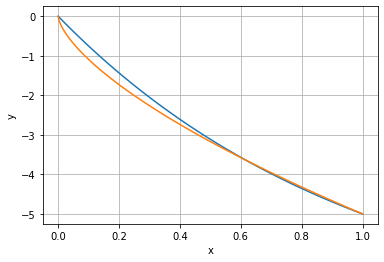

In [143]:
#Graficamos la funcion con nuestra estimacion inicial
xx = np.linspace(0,x2,100)
x,y, R = cycloid(x2,y2,100)
result = np.array([bspline(x, t,C0,k) + funcion_vector(x) for x in xx])
fig, ax = plt.subplots()
ax.plot(xx, result) 
ax.plot(x,y)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot()
ax.grid(True)
plt.show()

In [144]:
#Probamos que funcione la funcion para optimizar
print(J_for_min(C0))
#print(constraint4y(C0))

4.505976988971408


In [145]:
#Calculamos el minimo de la funcion
minimo = minimize(J_for_min,C0,method='CG',options={'gtol': 1e-08,'disp': True},jac=False)
#minimo = minimize(J_for_min,C0,method='trust-constr',constraints=const,\
#        options={'xtol': 1e-08,'gtol': 1e-08,'disp': True,'initial_constr_penalty': 100.0, 'initial_tr_radius': 1})

         Current function value: 4.490499
         Iterations: 200
         Function evaluations: 12680
         Gradient evaluations: 409


In [146]:
#La entrada x del diccionario  que regresa minimize es nuestro parametro optimo
print("Valor minimo {} encontrado en\n {}".format(minimo.fun,minimo.x))


Valor minimo 4.490498805184556 encontrado en
 [-1.10552364e+00 -9.38981559e-01 -1.00488556e+00 -9.44551331e-01
 -9.19397200e-01 -8.64116399e-01 -8.07443200e-01 -7.42626852e-01
 -6.67048908e-01 -5.91993319e-01 -5.17011799e-01 -4.43380683e-01
 -3.73274624e-01 -3.07977368e-01 -2.48655423e-01 -1.96011385e-01
 -1.50414232e-01 -1.11943335e-01 -8.02939017e-02 -5.51895483e-02
 -3.56777492e-02 -2.02678365e-02 -1.14685069e-02 -5.12373021e-03
 -1.82792107e-03 -1.58699492e-04  1.87627652e-04  1.93586471e-04
 -3.35040733e-04]


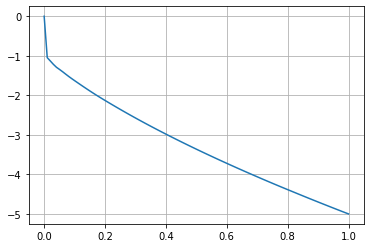

In [147]:
#Graficamos la solucion aproximada calculada en este código
result = np.array([bspline(x, t,minimo.x,k) + funcion_vector(x) for x in xx])
fig, ax = plt.subplots()
ax.plot(xx, result) 
ax.plot()
ax.grid(True)
plt.show() 

In [148]:
#Generamos los valores de la cicloide para su comparacion
x,y, R = cycloid(x2,y2,100)

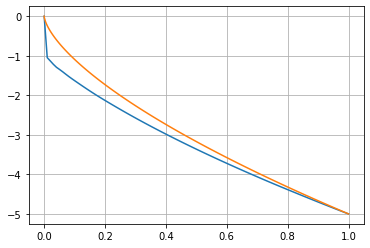

In [149]:
#Se comparan las soluciones exactas con las soluciones aproximadas calculadas
fig, ax = plt.subplots()
ax.plot(xx, result) 
ax.plot(x,y)
ax.plot()
ax.grid(True)
plt.show() #Graficamos la aproximacion a la solucion del problema

In [150]:
#Inicializamos los arreglos para calcular el error cuadrático medio
yi = np.zeros(nbp) #Los valores exactos
yi_hat = np.zeros(nbp) #Los valores estimados
li = np.zeros(nbp) #Las longitudes de los intervalos
for i in range(nbp-1):
    li[i] = t[i+1] - t[i] 
    yi_hat[i] = bspline((t[i]+t[i+1])/2, t,minimo['x'],k) + funcion_vector((t[i]+t[i+1])/2)
    yi[i] = ycycloid((t[i]+t[i+1])/2, R)
E = np.sqrt(sum(((yi - yi_hat)**2)*li)) #Se calcula el error cuadrático medio

In [151]:
E #El error cuadrático medio para nc = 16.

0.30570092521853887